In [13]:
import os
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables and find repo root
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

repo_root = find_repo_root()

# Load clinical data
clinical_path = repo_root / os.getenv("CLINICAL")
clinical_df = pd.read_csv(clinical_path, index_col=0)

# Load expression (z-scored) data
zscored_path = repo_root / os.getenv("ZSCORED_QUALITY_CHECKED")
zscored_df = pd.read_csv(zscored_path, index_col=0)

# Make sure both dataframes have the same samples and are in the same order
common_samples = clinical_df.index.intersection(zscored_df.index)
clinical_df = clinical_df.loc[common_samples]
zscored_df = zscored_df.loc[common_samples]


collapsed_path = repo_root / os.getenv("EM_COLLAPSED")
collapsed_df = pd.read_csv(collapsed_path, index_col=0)

common_samples = clinical_df.index.intersection(collapsed_df.index)
clinical_df = clinical_df.loc[common_samples]
collapsed_df = collapsed_df.loc[common_samples]

print(f"Zscored data shape: {zscored_df.shape}")
print(f"Collapsed (not zscored) data shape: {collapsed_df.shape}")
print(f"Clinical data shape: {clinical_df.shape}")

Zscored data shape: (3273, 26150)
Collapsed (not zscored) data shape: (3273, 26150)
Clinical data shape: (3273, 34)


In [14]:
from sklearn.manifold import TSNE

N = 5000  # or another number you prefer
gene_variances = zscored_df.var(axis=0)
top_genes = gene_variances.sort_values(ascending=False).head(N).index
zscored_df = zscored_df[top_genes]


In [15]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(zscored_df.values)

# Make a DataFrame for plotting/joining with clinical metadata
tsne_df = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'], index=zscored_df.index)
tsne_df = tsne_df.join(clinical_df)


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


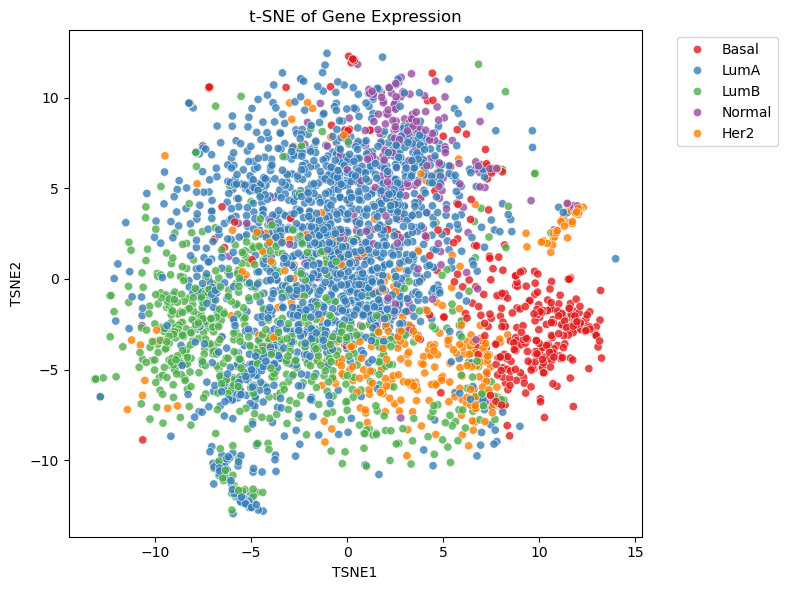

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='TSNE1', y='TSNE2',
    data=tsne_df,
    hue='OG_pam50 subtype',  # Change as needed
    palette='Set1',
    alpha=0.8
)
plt.title('t-SNE of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder().fit_transform(clinical_df['OG_pam50 subtype'].astype(str))
sil_tsne = silhouette_score(tsne_result, labels)
print(f"t-SNE Silhouette Score (w.r.t OG_pam50 subtype): {sil_tsne:.3f}")


t-SNE Silhouette Score (w.r.t OG_pam50 subtype): -0.019
